In [1]:
import os
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from pycocotools.coco import COCO
import random

In [2]:
# Check and enable GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# ------------------------------------------------------------------
# 1) DATASET PATHS
# ------------------------------------------------------------------
train_folder_path = "train/"
valid_folder_path = "valid/"
test_folder_path = "test/"
train_coco_json = "_annotations_train.coco.json"
valid_coco_json = "_annotations_valid.coco.json"
test_coco_json = "_annotations_test.coco.json"

In [4]:
# ------------------------------------------------------------------
# 2) LOAD COCO ANNOTATIONS
# ------------------------------------------------------------------
def load_coco_annotations(folder_path, coco_json):
    coco = COCO(os.path.join(folder_path, coco_json))
    images = []
    masks = []

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(folder_path, img_info['file_name'])
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Load image (256x256, grayscale, normalized)
        img = tf.keras.preprocessing.image.load_img(
            img_path, color_mode="grayscale", target_size=(256, 256)
        )
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0

        # Create mask
        mask = np.zeros((img.shape[0], img.shape[1]))
        for ann in anns:
            binary_mask = coco.annToMask(ann)
            binary_mask = tf.cast(binary_mask, tf.float32)
            if binary_mask.shape != (img.shape[0], img.shape[1]):
                binary_mask = tf.image.resize(binary_mask[..., None], (img.shape[0], img.shape[1]))
                binary_mask = tf.squeeze(binary_mask).numpy()
            mask = np.maximum(mask, binary_mask)

        mask = tf.image.resize(mask[..., None], (256, 256))
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [5]:
# Load data
X_train, y_train = load_coco_annotations(train_folder_path, train_coco_json)
X_val, y_val = load_coco_annotations(valid_folder_path, valid_coco_json)
X_test, y_test = load_coco_annotations(test_folder_path, test_coco_json)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2025-01-06 23:05:06.321918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-06 23:05:06.321950: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-06 23:05:06.321963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-06 23:05:06.321984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-06 23:05:06.322002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
# Ensure correct shape (expand dims again if needed)
y_train = np.expand_dims(y_train[..., 0], axis=-1)
y_val   = np.expand_dims(y_val[..., 0], axis=-1)
y_test  = np.expand_dims(y_test[..., 0], axis=-1)

In [7]:
# ------------------------------------------------------------------
# 3) DATA AUGMENTATION
# ------------------------------------------------------------------
data_gen_args = dict(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen  = ImageDataGenerator(**data_gen_args)

In [8]:
# Custom data generator
class CustomDataGenerator(Sequence):
    def __init__(self, image_generator, mask_generator):
        self.image_generator = image_generator
        self.mask_generator  = mask_generator

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        x = self.image_generator[index]
        y = self.mask_generator[index]
        return x, y

In [9]:
# Prepare data generators
seed = 42
image_generator = image_datagen.flow(X_train, batch_size=8, seed=seed)  # smaller batch
mask_generator  = mask_datagen.flow(y_train, batch_size=8, seed=seed)
train_generator = CustomDataGenerator(image_generator, mask_generator)

In [10]:
# ------------------------------------------------------------------
# 4) BUILD U-NET++ MODEL
# ------------------------------------------------------------------
def conv_block(inputs, filters, kernel_size=(3,3), padding="same", activation="relu"):
    x = layers.Conv2D(filters, kernel_size, padding=padding)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, kernel_size, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

In [11]:
def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

In [12]:
def decoder_block(inputs, skip_features, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, filters)
    return x

In [13]:
def unet_plus_plus(input_shape=(256, 256, 1), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)
    b1 = layers.Lambda(lambda x: tf.nn.dropout(x, rate=0.1))(b1)

    # Decoder
    d4 = decoder_block(b1, s4, 512)
    d4 = layers.Lambda(lambda x: tf.nn.dropout(x, rate=0.1))(d4)
    d3 = decoder_block(d4, s3, 256)
    d2 = decoder_block(d3, s2, 128)
    d1 = decoder_block(d2, s1, 64)

    outputs = layers.Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(d1)
    model = models.Model(inputs, outputs, name="U_Net_PlusPlus")
    return model

In [14]:
# ------------------------------------------------------------------
# 5) CUSTOM METRICS/LOSSES
# ------------------------------------------------------------------
def iou_score(y_true, y_pred, smooth=1e-7):
    """
    Intersection over Union = (TP) / (TP + FP + FN)
    We'll threshold y_pred at 0.5 for the predicted mask.
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [15]:
def dice_coefficient(y_true, y_pred, smooth=1e-7):
    """
    Dice = (2 * TP) / (2 * TP + FP + FN)
    We'll threshold y_pred at 0.5 for the predicted mask.
    """
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [16]:
def bce_dice_loss(y_true, y_pred):
    """
    Combined BCE + (1 - Dice).
    This helps address class imbalance by focusing on overlap.
    """
    bce  = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    return bce + (1.0 - dice)

In [17]:
# ------------------------------------------------------------------
# 6) TRAIN THE MODEL
# ------------------------------------------------------------------
strategy = tf.distribute.MirroredStrategy()  # If you have multiple GPUs
with strategy.scope():
    model = unet_plus_plus(input_shape=(256, 256, 1), num_classes=1)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,  # <-- Use BCE + Dice
        metrics=["accuracy", iou_score, dice_coefficient]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [18]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint("unetplusplus_best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
]

In [19]:
history = model.fit(
    train_generator,
    epochs=50,  # more epochs so we can see if it converges
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

/Users/arunalagusunthram/Desktop/Dev/AI/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-06 23:06:20.707297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.8353 - dice_coefficient: 0.0809 - iou_score: 0.0430 - loss: 1.3325

2025-01-06 23:14:39.411199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:14:39.411242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8358 - dice_coefficient: 0.0808 - iou_score: 0.0429 - loss: 1.3318

2025-01-06 23:15:19.011851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:15:19.011905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.8362 - dice_coefficient: 0.0808 - iou_score: 0.0429 - loss: 1.3311 - val_accuracy: 0.9626 - val_dice_coefficient: 1.4250e-12 - val_iou_score: 1.4250e-12 - val_loss: 1.4093 - learning_rate: 1.0000e-04
Epoch 2/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9605 - dice_coefficient: 0.1570 - iou_score: 0.0912 - loss: 1.0141

2025-01-06 23:23:59.342609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:23:59.342648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9605 - dice_coefficient: 0.1575 - iou_score: 0.0915 - loss: 1.0135

2025-01-06 23:24:38.660307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:24:38.660421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 558s 3s/step - accuracy: 0.9605 - dice_coefficient: 0.1580 - iou_score: 0.0919 - loss: 1.0130 - val_accuracy: 0.3498 - val_dice_coefficient: 0.0988 - val_iou_score: 0.0520 - val_loss: 1.9011 - learning_rate: 1.0000e-04
Epoch 3/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9666 - dice_coefficient: 0.4502 - iou_score: 0.2976 - loss: 0.6810

2025-01-06 23:32:45.482742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:32:45.482788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9666 - dice_coefficient: 0.4502 - iou_score: 0.2976 - loss: 0.6810

2025-01-06 23:33:21.747293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:33:21.747429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 524s 3s/step - accuracy: 0.9666 - dice_coefficient: 0.4502 - iou_score: 0.2976 - loss: 0.6809 - val_accuracy: 0.9344 - val_dice_coefficient: 0.2611 - val_iou_score: 0.1505 - val_loss: 0.9522 - learning_rate: 1.0000e-04
Epoch 4/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9681 - dice_coefficient: 0.4846 - iou_score: 0.3294 - loss: 0.6306

2025-01-06 23:41:17.197605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:41:17.197658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9681 - dice_coefficient: 0.4847 - iou_score: 0.3295 - loss: 0.6304

2025-01-06 23:41:53.305400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:41:53.305431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.9681 - dice_coefficient: 0.4848 - iou_score: 0.3296 - loss: 0.6303 - val_accuracy: 0.9696 - val_dice_coefficient: 0.5281 - val_iou_score: 0.3596 - val_loss: 0.5923 - learning_rate: 1.0000e-04
Epoch 5/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9695 - dice_coefficient: 0.5596 - iou_score: 0.3949 - loss: 0.5427

2025-01-06 23:49:49.752934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:49:49.752969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9695 - dice_coefficient: 0.5596 - iou_score: 0.3949 - loss: 0.5427

2025-01-06 23:50:26.462406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:50:26.462446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9695 - dice_coefficient: 0.5595 - iou_score: 0.3948 - loss: 0.5428 - val_accuracy: 0.9648 - val_dice_coefficient: 0.5462 - val_iou_score: 0.3767 - val_loss: 0.5638 - learning_rate: 1.0000e-04
Epoch 6/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9706 - dice_coefficient: 0.5752 - iou_score: 0.4108 - loss: 0.5195

2025-01-06 23:58:21.329031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:58:21.329095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9706 - dice_coefficient: 0.5752 - iou_score: 0.4108 - loss: 0.5194

2025-01-06 23:58:57.706841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-06 23:58:57.706873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.9706 - dice_coefficient: 0.5752 - iou_score: 0.4108 - loss: 0.5194 - val_accuracy: 0.9752 - val_dice_coefficient: 0.6219 - val_iou_score: 0.4531 - val_loss: 0.4572 - learning_rate: 1.0000e-04
Epoch 7/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9712 - dice_coefficient: 0.5995 - iou_score: 0.4360 - loss: 0.4882

2025-01-07 00:06:54.852360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:06:54.852407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9712 - dice_coefficient: 0.5995 - iou_score: 0.4360 - loss: 0.4882

2025-01-07 00:07:30.999409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:07:30.999453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.9712 - dice_coefficient: 0.5995 - iou_score: 0.4360 - loss: 0.4882 - val_accuracy: 0.9729 - val_dice_coefficient: 0.4677 - val_iou_score: 0.3084 - val_loss: 0.6126 - learning_rate: 1.0000e-04
Epoch 8/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9725 - dice_coefficient: 0.6054 - iou_score: 0.4426 - loss: 0.4761

2025-01-07 00:15:28.260017: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:15:28.260058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9725 - dice_coefficient: 0.6054 - iou_score: 0.4427 - loss: 0.4761

2025-01-07 00:16:04.613472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:16:04.613512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.9725 - dice_coefficient: 0.6054 - iou_score: 0.4427 - loss: 0.4760 - val_accuracy: 0.9745 - val_dice_coefficient: 0.6307 - val_iou_score: 0.4627 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 9/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6299 - iou_score: 0.4683 - loss: 0.4484

2025-01-07 00:24:01.596697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:24:01.596743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6299 - iou_score: 0.4683 - loss: 0.4483

2025-01-07 00:24:37.513664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:24:37.513692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6299 - iou_score: 0.4683 - loss: 0.4483 - val_accuracy: 0.9652 - val_dice_coefficient: 0.5264 - val_iou_score: 0.3597 - val_loss: 0.5680 - learning_rate: 1.0000e-04
Epoch 10/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6279 - iou_score: 0.4650 - loss: 0.4467

2025-01-07 00:32:31.747072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:32:31.747125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6280 - iou_score: 0.4651 - loss: 0.4467

2025-01-07 00:33:08.237543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:33:08.237597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 511s 3s/step - accuracy: 0.9729 - dice_coefficient: 0.6281 - iou_score: 0.4652 - loss: 0.4466 - val_accuracy: 0.9749 - val_dice_coefficient: 0.5885 - val_iou_score: 0.4196 - val_loss: 0.4812 - learning_rate: 1.0000e-04
Epoch 11/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9737 - dice_coefficient: 0.6637 - iou_score: 0.5028 - loss: 0.4071

2025-01-07 00:41:21.504295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:41:21.504341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9737 - dice_coefficient: 0.6637 - iou_score: 0.5028 - loss: 0.4071

2025-01-07 00:42:01.731351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:42:01.731417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.9737 - dice_coefficient: 0.6636 - iou_score: 0.5027 - loss: 0.4072 - val_accuracy: 0.9774 - val_dice_coefficient: 0.6131 - val_iou_score: 0.4446 - val_loss: 0.4488 - learning_rate: 1.0000e-04
Epoch 12/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9765 - dice_coefficient: 0.6720 - iou_score: 0.5126 - loss: 0.3909

2025-01-07 00:52:38.930345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:52:38.930386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9765 - dice_coefficient: 0.6720 - iou_score: 0.5127 - loss: 0.3908

2025-01-07 00:53:26.613995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 00:53:26.614059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 685s 4s/step - accuracy: 0.9765 - dice_coefficient: 0.6720 - iou_score: 0.5127 - loss: 0.3908 - val_accuracy: 0.9747 - val_dice_coefficient: 0.5189 - val_iou_score: 0.3525 - val_loss: 0.5521 - learning_rate: 5.0000e-05
Epoch 13/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9748 - dice_coefficient: 0.6863 - iou_score: 0.5292 - loss: 0.3786

2025-01-07 01:03:48.517466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:03:48.517511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9748 - dice_coefficient: 0.6864 - iou_score: 0.5292 - loss: 0.3786

2025-01-07 01:03:51.893773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:03:51.896258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 01:04:35.540457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:04:35.540490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 670s 4s/step - accuracy: 0.9749 - dice_coefficient: 0.6864 - iou_score: 0.5292 - loss: 0.3786 - val_accuracy: 0.9802 - val_dice_coefficient: 0.7061 - val_iou_score: 0.5477 - val_loss: 0.3475 - learning_rate: 5.0000e-05
Epoch 14/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9771 - dice_coefficient: 0.6996 - iou_score: 0.5447 - loss: 0.3601

2025-01-07 01:14:58.074323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:14:58.074367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9771 - dice_coefficient: 0.6996 - iou_score: 0.5447 - loss: 0.3602

2025-01-07 01:15:46.498749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:15:46.498801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 670s 4s/step - accuracy: 0.9771 - dice_coefficient: 0.6996 - iou_score: 0.5447 - loss: 0.3602 - val_accuracy: 0.9788 - val_dice_coefficient: 0.6542 - val_iou_score: 0.4899 - val_loss: 0.4015 - learning_rate: 5.0000e-05
Epoch 15/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9761 - dice_coefficient: 0.6850 - iou_score: 0.5277 - loss: 0.3749

2025-01-07 01:26:17.364093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:26:17.364135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9761 - dice_coefficient: 0.6850 - iou_score: 0.5277 - loss: 0.3748

2025-01-07 01:26:21.138928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:26:21.139001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 01:27:05.458531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:27:05.458613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.9761 - dice_coefficient: 0.6851 - iou_score: 0.5278 - loss: 0.3748 - val_accuracy: 0.9789 - val_dice_coefficient: 0.6436 - val_iou_score: 0.4773 - val_loss: 0.4109 - learning_rate: 5.0000e-05
Epoch 16/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9785 - dice_coefficient: 0.7109 - iou_score: 0.5585 - loss: 0.3450

2025-01-07 01:37:49.754880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:37:49.754930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9785 - dice_coefficient: 0.7109 - iou_score: 0.5586 - loss: 0.3450

2025-01-07 01:38:38.954434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:38:38.954470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 16: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 694s 4s/step - accuracy: 0.9785 - dice_coefficient: 0.7109 - iou_score: 0.5586 - loss: 0.3450 - val_accuracy: 0.9798 - val_dice_coefficient: 0.6854 - val_iou_score: 0.5235 - val_loss: 0.3674 - learning_rate: 5.0000e-05
Epoch 17/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9779 - dice_coefficient: 0.7254 - iou_score: 0.5754 - loss: 0.3301

2025-01-07 01:49:15.068169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:49:15.068214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9779 - dice_coefficient: 0.7254 - iou_score: 0.5754 - loss: 0.3301

2025-01-07 01:49:18.282661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:49:18.282729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 01:49:57.454726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:49:57.454761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 678s 4s/step - accuracy: 0.9779 - dice_coefficient: 0.7254 - iou_score: 0.5754 - loss: 0.3301 - val_accuracy: 0.9800 - val_dice_coefficient: 0.6762 - val_iou_score: 0.5144 - val_loss: 0.3734 - learning_rate: 2.5000e-05
Epoch 18/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9789 - dice_coefficient: 0.7292 - iou_score: 0.5786 - loss: 0.3235

2025-01-07 01:58:32.454136: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:58:32.454185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9789 - dice_coefficient: 0.7292 - iou_score: 0.5786 - loss: 0.3235

2025-01-07 01:59:10.916815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 01:59:10.916883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.9789 - dice_coefficient: 0.7293 - iou_score: 0.5786 - loss: 0.3235 - val_accuracy: 0.9804 - val_dice_coefficient: 0.6956 - val_iou_score: 0.5352 - val_loss: 0.3553 - learning_rate: 2.5000e-05
Epoch 19/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7438 - iou_score: 0.5966 - loss: 0.3065

2025-01-07 02:07:30.044332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:07:30.044406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7438 - iou_score: 0.5966 - loss: 0.3065

2025-01-07 02:07:32.879195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:07:32.879250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 02:08:08.889464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:08:08.889522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 19: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 538s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7438 - iou_score: 0.5966 - loss: 0.3065 - val_accuracy: 0.9806 - val_dice_coefficient: 0.6969 - val_iou_score: 0.5375 - val_loss: 0.3547 - learning_rate: 2.5000e-05
Epoch 20/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9793 - dice_coefficient: 0.7443 - iou_score: 0.5985 - loss: 0.3060

2025-01-07 02:16:35.213620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:16:35.213668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9793 - dice_coefficient: 0.7443 - iou_score: 0.5985 - loss: 0.3060

2025-01-07 02:16:38.072343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:16:38.072423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 02:17:14.104561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:17:14.104611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.9793 - dice_coefficient: 0.7443 - iou_score: 0.5985 - loss: 0.3060 - val_accuracy: 0.9820 - val_dice_coefficient: 0.7374 - val_iou_score: 0.5860 - val_loss: 0.3100 - learning_rate: 1.2500e-05
Epoch 21/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7555 - iou_score: 0.6113 - loss: 0.2929

2025-01-07 02:25:48.834718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:25:48.834800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7555 - iou_score: 0.6113 - loss: 0.2928

2025-01-07 02:26:27.665361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:26:27.665400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.9801 - dice_coefficient: 0.7555 - iou_score: 0.6113 - loss: 0.2928 - val_accuracy: 0.9812 - val_dice_coefficient: 0.7272 - val_iou_score: 0.5736 - val_loss: 0.3215 - learning_rate: 1.2500e-05
Epoch 22/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9795 - dice_coefficient: 0.7497 - iou_score: 0.6037 - loss: 0.3000

2025-01-07 02:34:56.435880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:34:56.435932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9795 - dice_coefficient: 0.7498 - iou_score: 0.6038 - loss: 0.3000

2025-01-07 02:34:59.381074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:34:59.381123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 02:35:35.430435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:35:35.430459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.9795 - dice_coefficient: 0.7498 - iou_score: 0.6038 - loss: 0.3000 - val_accuracy: 0.9816 - val_dice_coefficient: 0.7348 - val_iou_score: 0.5830 - val_loss: 0.3132 - learning_rate: 1.2500e-05
Epoch 23/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7595 - iou_score: 0.6167 - loss: 0.2873

2025-01-07 02:44:01.940953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:44:01.941022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7595 - iou_score: 0.6167 - loss: 0.2873

2025-01-07 02:44:40.643144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:44:40.643172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 23: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
188/188 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7595 - iou_score: 0.6167 - loss: 0.2873 - val_accuracy: 0.9810 - val_dice_coefficient: 0.7138 - val_iou_score: 0.5579 - val_loss: 0.3359 - learning_rate: 1.2500e-05
Epoch 24/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7639 - iou_score: 0.6220 - loss: 0.2816

2025-01-07 02:53:18.245299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:53:18.245341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9809 - dice_coefficient: 0.7639 - iou_score: 0.6220 - loss: 0.2816

2025-01-07 02:53:57.117499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 02:53:57.117522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.9810 - dice_coefficient: 0.7639 - iou_score: 0.6220 - loss: 0.2816 - val_accuracy: 0.9819 - val_dice_coefficient: 0.7241 - val_iou_score: 0.5698 - val_loss: 0.3225 - learning_rate: 6.2500e-06
Epoch 25/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7737 - iou_score: 0.6345 - loss: 0.2692

2025-01-07 03:02:25.809620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:02:25.809681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7736 - iou_score: 0.6344 - loss: 0.2692

2025-01-07 03:03:05.164706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:03:05.164776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7736 - iou_score: 0.6344 - loss: 0.2693 - val_accuracy: 0.9822 - val_dice_coefficient: 0.7525 - val_iou_score: 0.6052 - val_loss: 0.2943 - learning_rate: 6.2500e-06
Epoch 26/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9811 - dice_coefficient: 0.7677 - iou_score: 0.6266 - loss: 0.2778

2025-01-07 03:11:35.424435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:11:35.424486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9811 - dice_coefficient: 0.7677 - iou_score: 0.6266 - loss: 0.2778

2025-01-07 03:12:14.291543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:12:14.291580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.9811 - dice_coefficient: 0.7677 - iou_score: 0.6266 - loss: 0.2778 - val_accuracy: 0.9821 - val_dice_coefficient: 0.7306 - val_iou_score: 0.5777 - val_loss: 0.3162 - learning_rate: 6.2500e-06
Epoch 27/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7776 - iou_score: 0.6397 - loss: 0.2663

2025-01-07 03:20:45.009691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:20:45.009740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7776 - iou_score: 0.6397 - loss: 0.2663

2025-01-07 03:21:24.035636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:21:24.035672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7776 - iou_score: 0.6397 - loss: 0.2663 - val_accuracy: 0.9822 - val_dice_coefficient: 0.7424 - val_iou_score: 0.5920 - val_loss: 0.3043 - learning_rate: 6.2500e-06
Epoch 28/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9816 - dice_coefficient: 0.7692 - iou_score: 0.6294 - loss: 0.2751

2025-01-07 03:29:57.954960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:29:57.954999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9816 - dice_coefficient: 0.7692 - iou_score: 0.6294 - loss: 0.2751

2025-01-07 03:30:36.704922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:30:36.704977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 28: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
188/188 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.9816 - dice_coefficient: 0.7692 - iou_score: 0.6294 - loss: 0.2751 - val_accuracy: 0.9818 - val_dice_coefficient: 0.7281 - val_iou_score: 0.5744 - val_loss: 0.3185 - learning_rate: 6.2500e-06
Epoch 29/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7815 - iou_score: 0.6448 - loss: 0.2604

2025-01-07 03:39:03.957045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:39:03.957108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7815 - iou_score: 0.6448 - loss: 0.2604

2025-01-07 03:39:06.925230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:39:06.925288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-01-07 03:39:42.666593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:39:42.666646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.9826 - dice_coefficient: 0.7815 - iou_score: 0.6448 - loss: 0.2604 - val_accuracy: 0.9821 - val_dice_coefficient: 0.7416 - val_iou_score: 0.5912 - val_loss: 0.3048 - learning_rate: 3.1250e-06
Epoch 30/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9816 - dice_coefficient: 0.7803 - iou_score: 0.6427 - loss: 0.2638

2025-01-07 03:48:13.280184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:48:13.280286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9816 - dice_coefficient: 0.7803 - iou_score: 0.6427 - loss: 0.2638

2025-01-07 03:48:52.003526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:48:52.003563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 549s 3s/step - accuracy: 0.9817 - dice_coefficient: 0.7802 - iou_score: 0.6427 - loss: 0.2638 - val_accuracy: 0.9821 - val_dice_coefficient: 0.7378 - val_iou_score: 0.5864 - val_loss: 0.3087 - learning_rate: 3.1250e-06
Epoch 31/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7804 - iou_score: 0.6439 - loss: 0.2623

2025-01-07 03:57:24.114492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:57:24.114534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7804 - iou_score: 0.6439 - loss: 0.2623

2025-01-07 03:58:03.163361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 03:58:03.163399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
188/188 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.9819 - dice_coefficient: 0.7804 - iou_score: 0.6438 - loss: 0.2624 - val_accuracy: 0.9820 - val_dice_coefficient: 0.7289 - val_iou_score: 0.5756 - val_loss: 0.3178 - learning_rate: 3.1250e-06
Epoch 32/50
187/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9822 - dice_coefficient: 0.7807 - iou_score: 0.6438 - loss: 0.2617

2025-01-07 04:06:33.970694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 04:06:33.970745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9822 - dice_coefficient: 0.7807 - iou_score: 0.6438 - loss: 0.2618

2025-01-07 04:07:12.775400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 04:07:12.775436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


188/188 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.9822 - dice_coefficient: 0.7806 - iou_score: 0.6438 - loss: 0.2618 - val_accuracy: 0.9822 - val_dice_coefficient: 0.7369 - val_iou_score: 0.5855 - val_loss: 0.3091 - learning_rate: 1.5625e-06


In [20]:
model.save("unetplusplus_final_model.keras")

In [21]:
# ------------------------------------------------------------------
# 7) EVALUATE ON TEST SET
# ------------------------------------------------------------------
test_loss, test_accuracy, test_iou, test_dice = model.evaluate(X_test, y_test, batch_size=8)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test IOU: {test_iou}")
print(f"Test Dice: {test_dice}")

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9808 - dice_coefficient: 0.7461 - iou_score: 0.6002 - loss: 0.3063

2025-01-07 04:58:38.213114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 04:58:38.213222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 573ms/step - accuracy: 0.9809 - dice_coefficient: 0.7461 - iou_score: 0.6002 - loss: 0.3061
Test Loss: 0.3027607798576355
Test Accuracy: 0.981785237789154
Test IOU: 0.5999077558517456
Test Dice: 0.7461512684822083


In [22]:
# ------------------------------------------------------------------
# 8) PLOT METRICS
# ------------------------------------------------------------------
epochs_range = range(1, len(history.history['loss']) + 1)

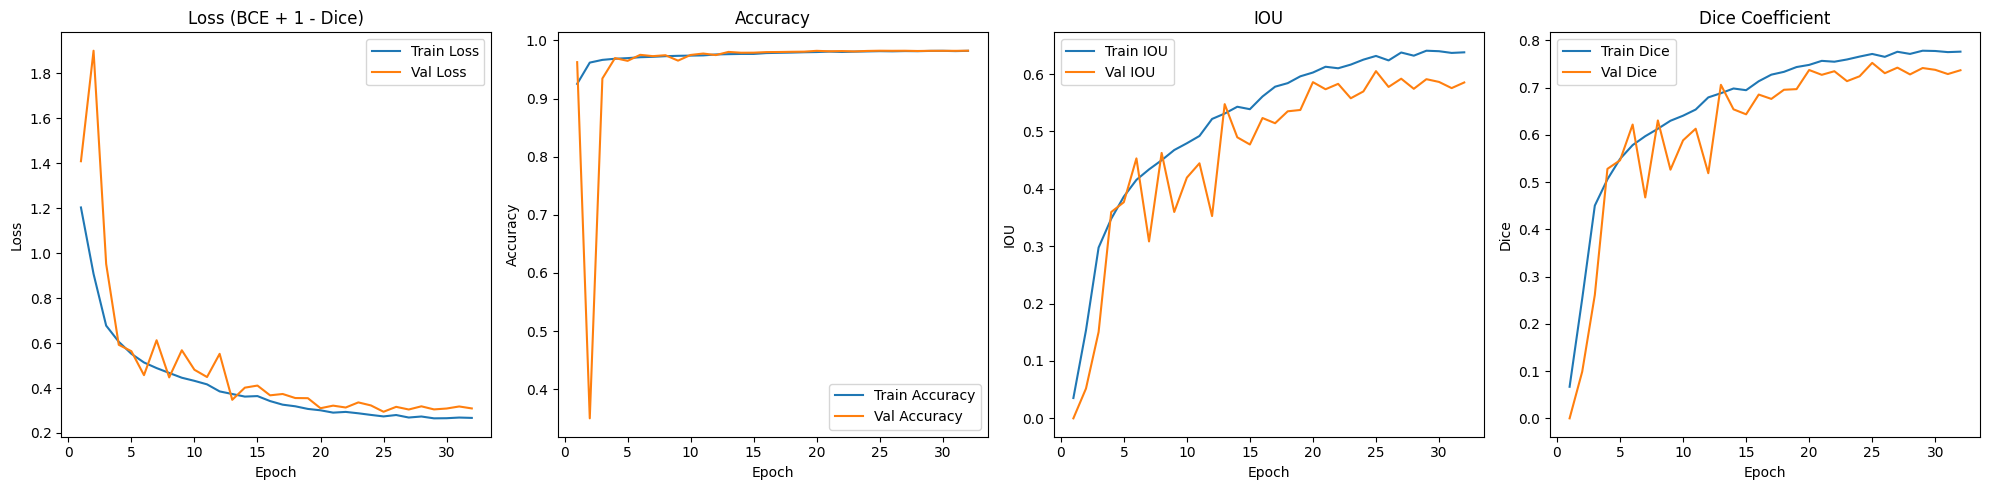

In [43]:
plt.figure(figsize=(20, 5))

# (a) LOSS PLOT
plt.subplot(1, 4, 1)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
# plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss (BCE + 1 - Dice)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# (b) ACCURACY PLOT
plt.subplot(1, 4, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
# plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# (c) IOU PLOT
plt.subplot(1, 4, 3)
plt.plot(epochs_range, history.history['iou_score'], label='Train IOU')
plt.plot(epochs_range, history.history['val_iou_score'], label='Val IOU')
# plt.axhline(y=test_iou, color='r', linestyle='--', label='Test IOU')
plt.title('IOU')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.legend()

# (d) DICE PLOT
plt.subplot(1, 4, 4)
plt.plot(epochs_range, history.history['dice_coefficient'], label='Train Dice')
plt.plot(epochs_range, history.history['val_dice_coefficient'], label='Val Dice')
# plt.axhline(y=test_dice, color='r', linestyle='--', label='Test Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.tight_layout()
plt.show()


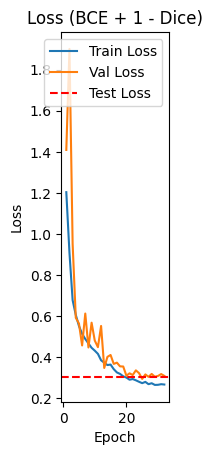

In [ ]:
# (a) LOSS PLOT
# plt.subplot(1, 4, 1)
# plt.plot(epochs_range, history.history['loss'], label='Train Loss')
# plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
# plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
# plt.title('Loss (BCE + 1 - Dice)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

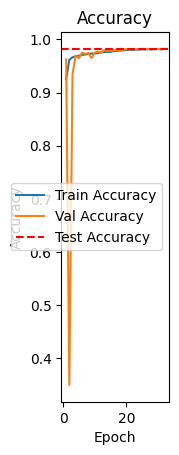

In [25]:
# # (b) ACCURACY PLOT
# plt.subplot(1, 4, 2)
# plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
# plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
# plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

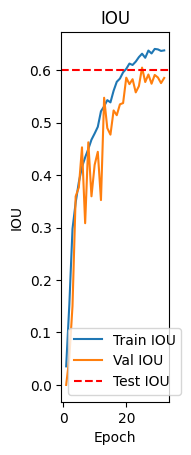

In [26]:
# # (c) IOU PLOT
# plt.subplot(1, 4, 3)
# plt.plot(epochs_range, history.history['iou_score'], label='Train IOU')
# plt.plot(epochs_range, history.history['val_iou_score'], label='Val IOU')
# plt.axhline(y=test_iou, color='r', linestyle='--', label='Test IOU')
# plt.title('IOU')
# plt.xlabel('Epoch')
# plt.ylabel('IOU')
# plt.legend()

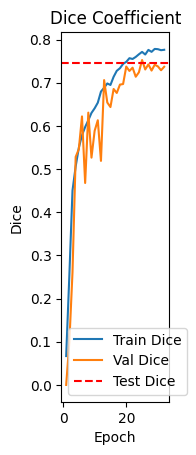

In [27]:
# # (d) DICE PLOT
# plt.subplot(1, 4, 4)
# plt.plot(epochs_range, history.history['dice_coefficient'], label='Train Dice')
# plt.plot(epochs_range, history.history['val_dice_coefficient'], label='Val Dice')
# plt.axhline(y=test_dice, color='r', linestyle='--', label='Test Dice')
# plt.title('Dice Coefficient')
# plt.xlabel('Epoch')
# plt.ylabel('Dice')
# plt.legend()

In [29]:
# plt.tight_layout()
# plt.show()

<Figure size 640x480 with 0 Axes>

In [30]:
# ------------------------------------------------------------------
# 9) VISUALIZE PREDICTIONS (COLORED OVERLAY)
# ------------------------------------------------------------------
def visualize_prediction(img, true_mask, pred_mask, threshold=0.5):
    """
    img: single image array of shape (256,256,1) in [0,1]
    true_mask: ground-truth mask array (256,256,1)
    pred_mask: predicted mask array (256,256,1)
    threshold: for binarizing predictions
    """
    img_rgb = np.repeat(img, 3, axis=-1)  # grayscale -> 3-channel
    img_rgb = np.clip(img_rgb, 0, 1)

    pred_binary = (pred_mask > threshold).astype(np.float32)

    # color overlays
    alpha = 0.4
    overlay_pred = img_rgb.copy()
    overlay_true = img_rgb.copy()

    # predicted mask -> red
    overlay_pred[..., 0] = np.where(pred_binary[..., 0] == 1, 1.0, overlay_pred[..., 0])
    overlay_pred[..., 1] = np.where(pred_binary[..., 0] == 1, 0.0, overlay_pred[..., 1])
    overlay_pred[..., 2] = np.where(pred_binary[..., 0] == 1, 0.0, overlay_pred[..., 2])

    # true mask -> green
    overlay_true[..., 0] = np.where(true_mask[..., 0] == 1, 0.0, overlay_true[..., 0])
    overlay_true[..., 1] = np.where(true_mask[..., 0] == 1, 1.0, overlay_true[..., 1])
    overlay_true[..., 2] = np.where(true_mask[..., 0] == 1, 0.0, overlay_true[..., 2])

    blended_pred = (1 - alpha) * img_rgb + alpha * overlay_pred
    blended_true = (1 - alpha) * img_rgb + alpha * overlay_true

    # Plot side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img.squeeze(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(blended_true)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(blended_pred)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step

2025-01-07 06:28:58.656384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:28:58.656426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
--- Displaying Test Image #1 (Index 113) ---


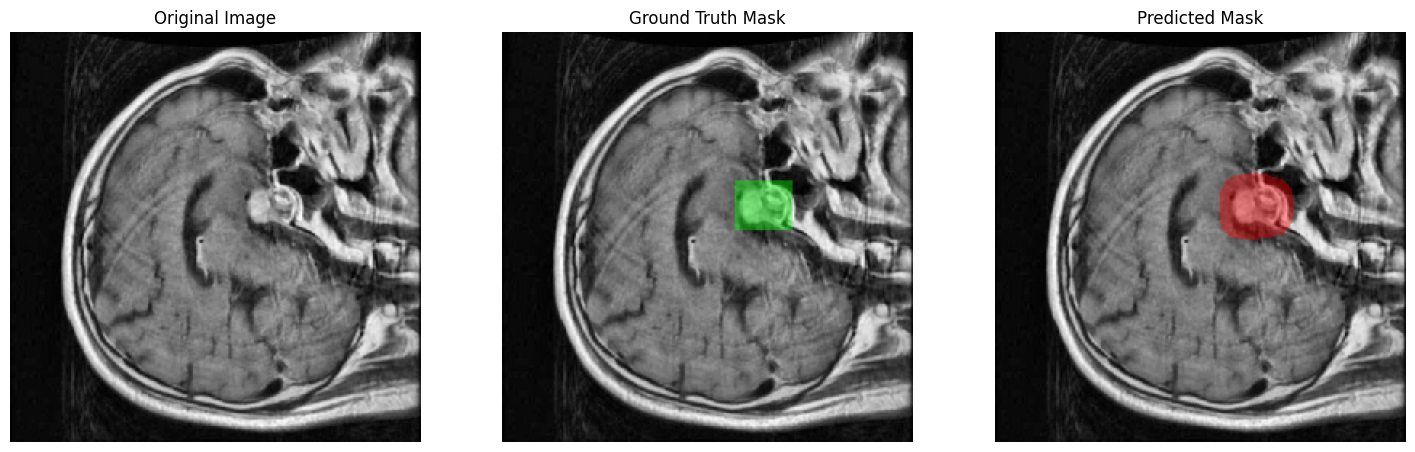

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


2025-01-07 06:28:59.137418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:28:59.137439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #2 (Index 104) ---


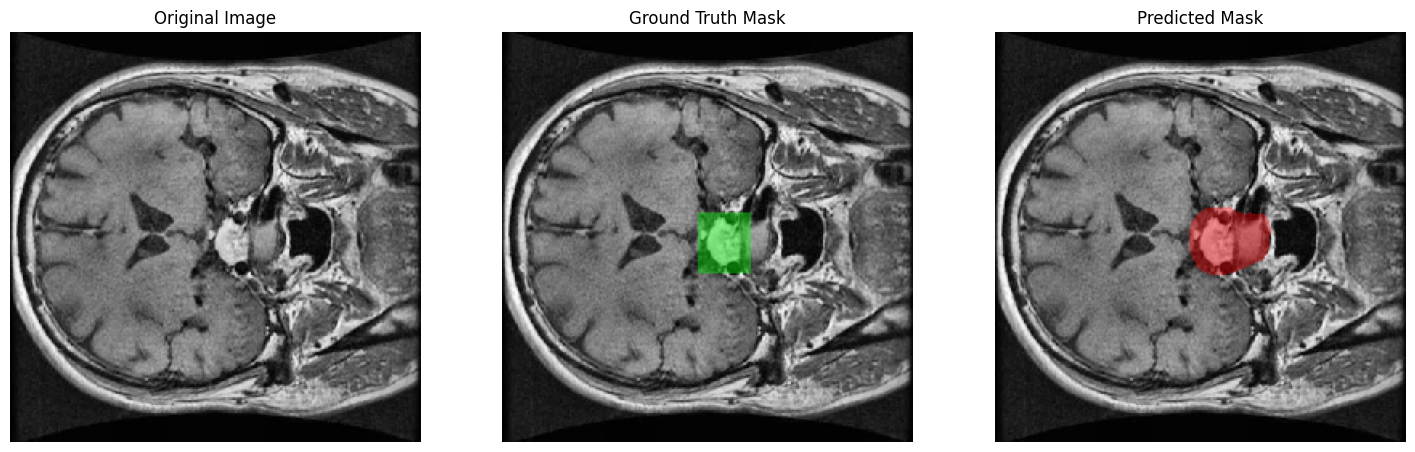

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


2025-01-07 06:28:59.536798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:28:59.536823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #3 (Index 214) ---


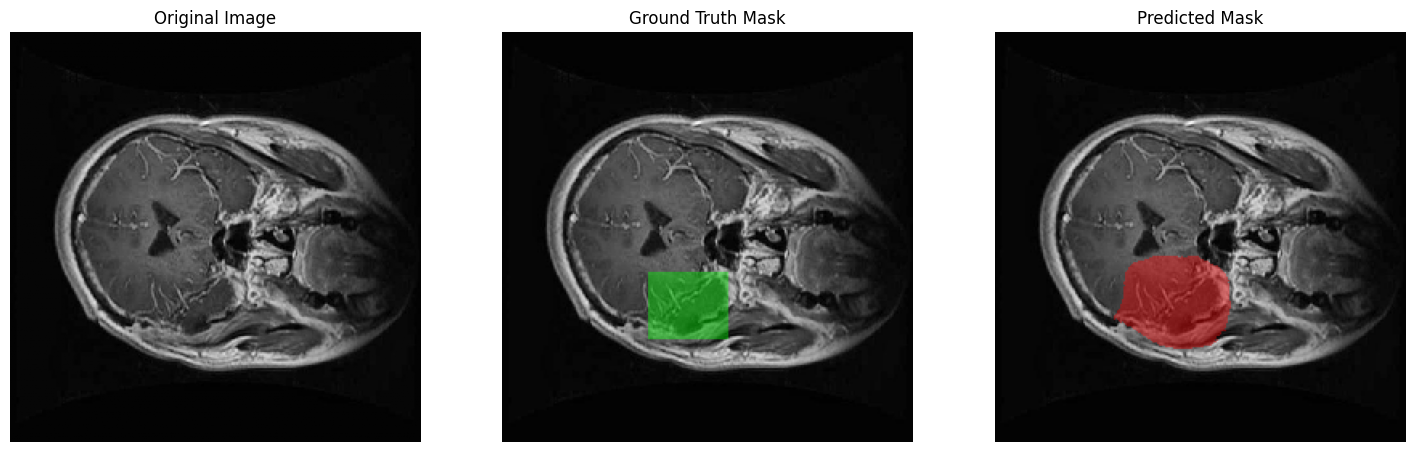

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


2025-01-07 06:28:59.894481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:28:59.894543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #4 (Index 128) ---


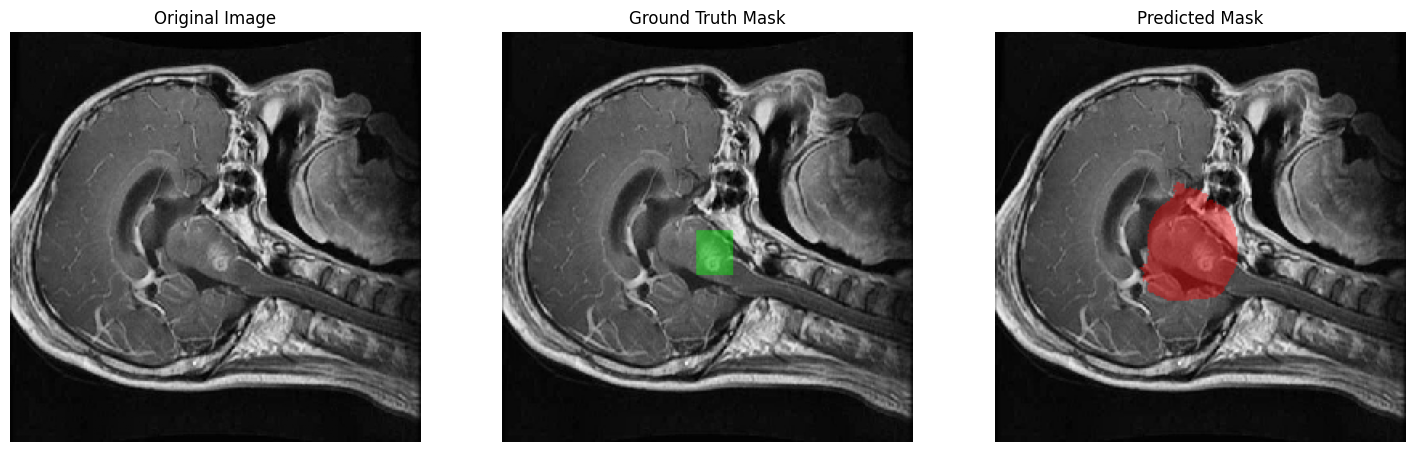

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


2025-01-07 06:29:00.352383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:00.352451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #5 (Index 37) ---


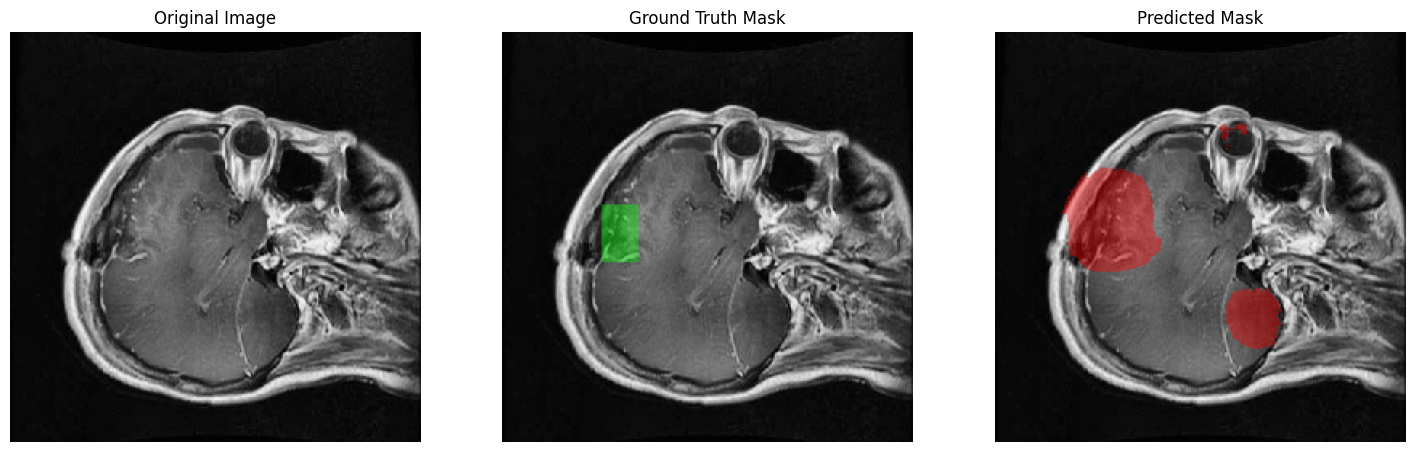

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

2025-01-07 06:29:00.718857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:00.718893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
--- Displaying Test Image #6 (Index 162) ---


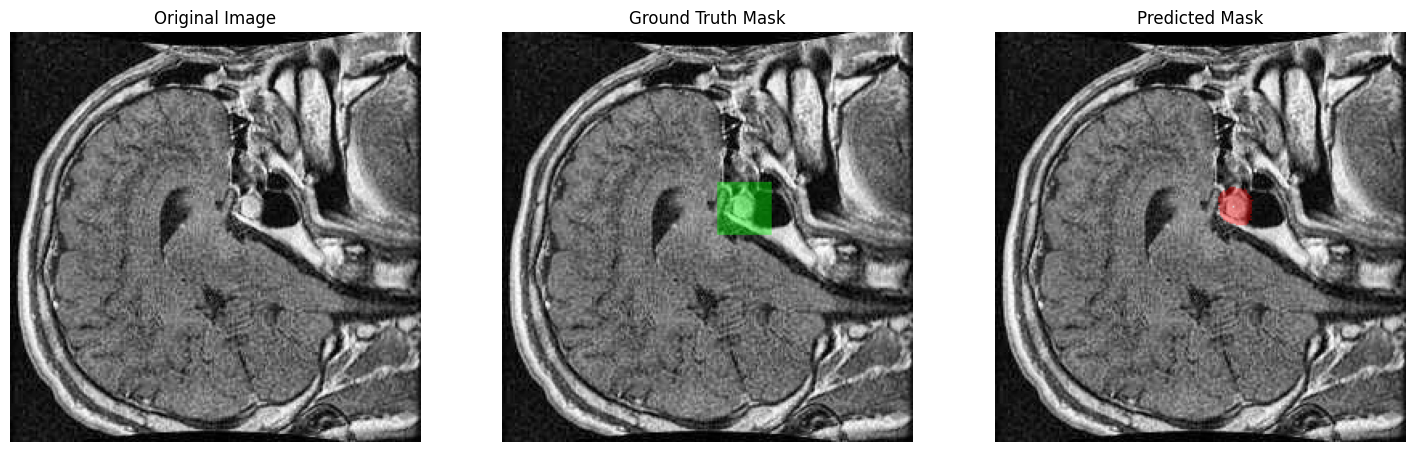

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


2025-01-07 06:29:01.267187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:01.267209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #7 (Index 109) ---


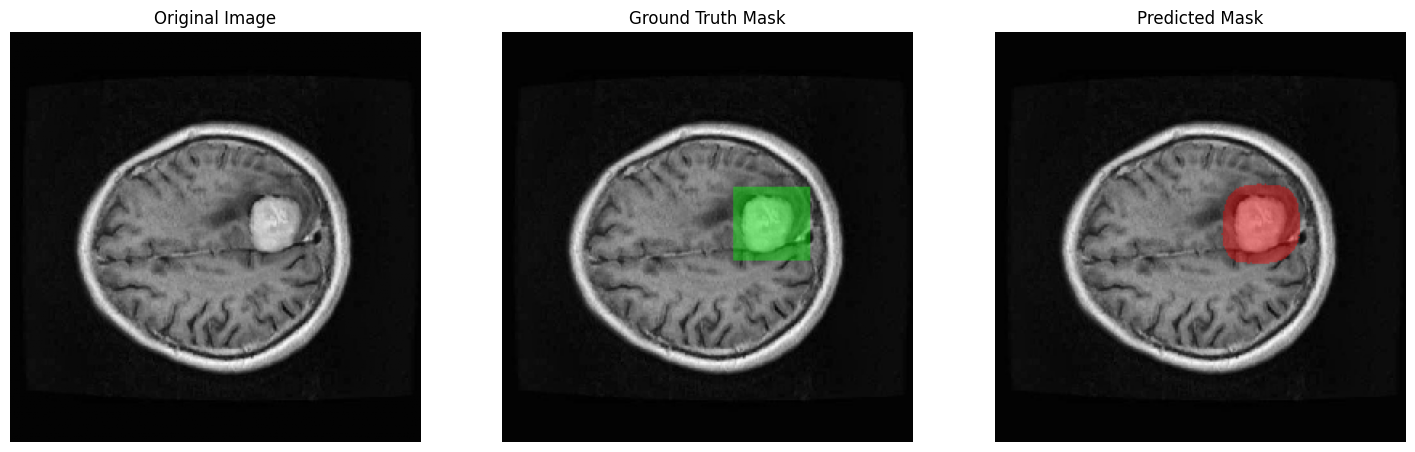

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2025-01-07 06:29:01.660292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:01.660328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #8 (Index 51) ---


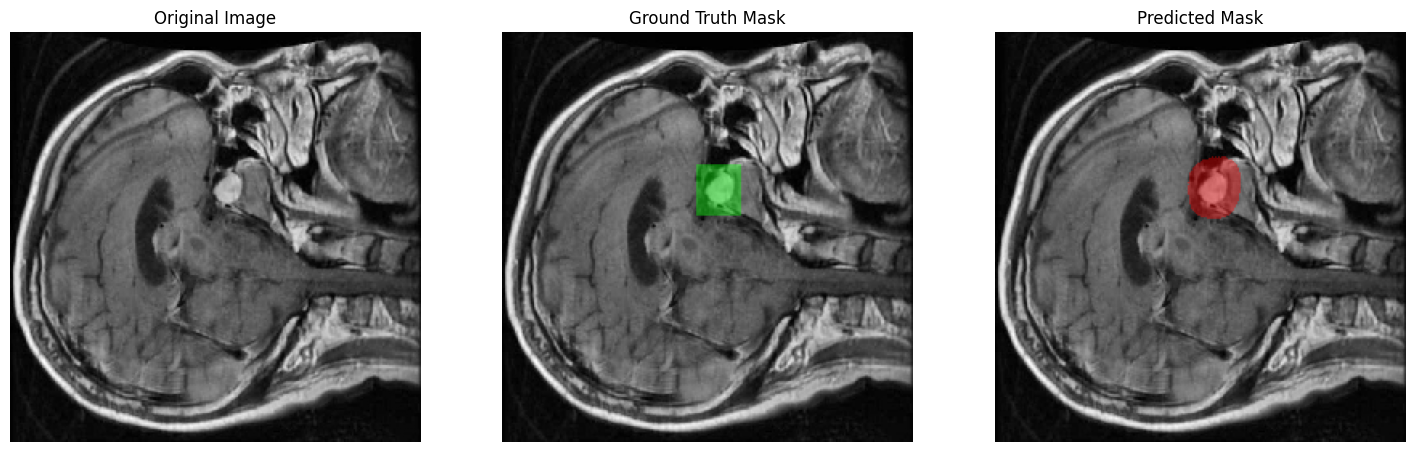

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


2025-01-07 06:29:02.078094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:02.078143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #9 (Index 67) ---


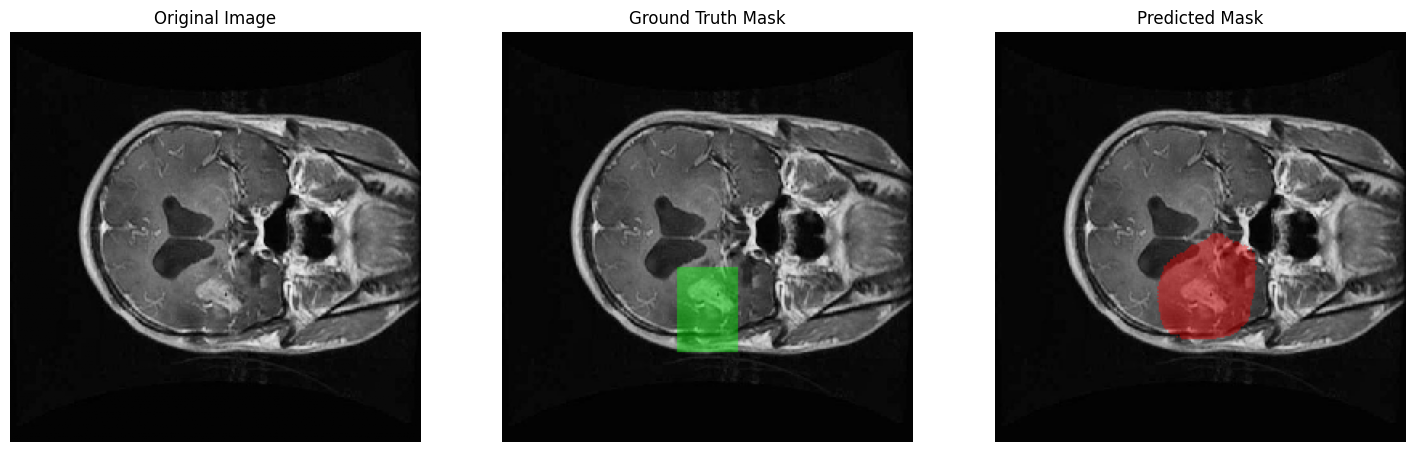

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


2025-01-07 06:29:02.467792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2025-01-07 06:29:02.467839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
	 [[RemoteCall]]


--- Displaying Test Image #10 (Index 177) ---


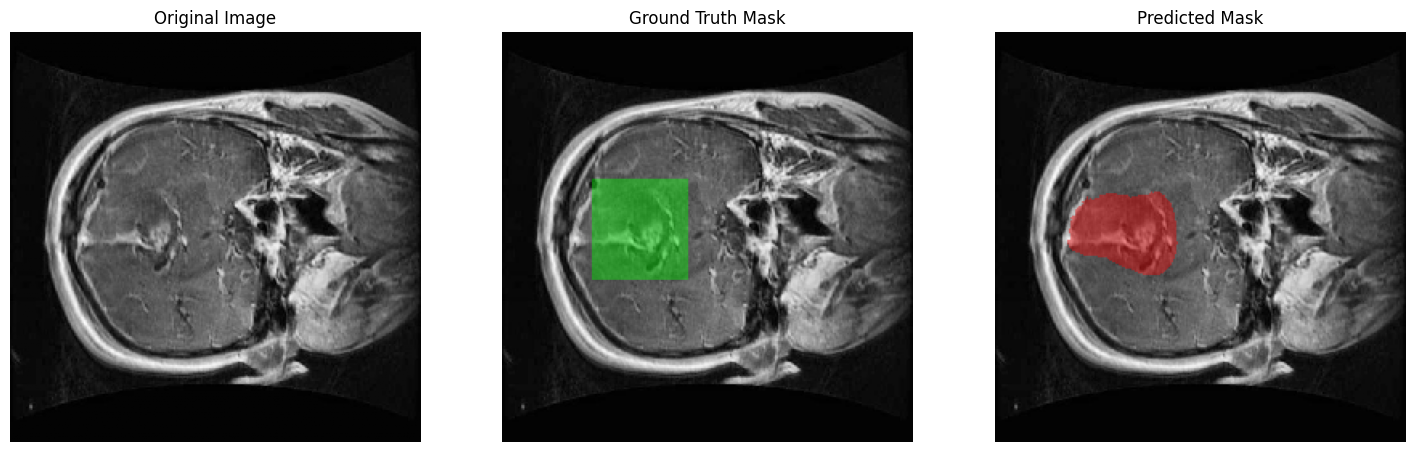

In [42]:
# ------------------------------------------------------------------
# 10) TEST EXAMPLE VISUALIZATION (FOR 5 RANDOM IMAGES)
# ------------------------------------------------------------------
num_images_to_display = 10

for i in range(num_images_to_display):
    # Pick a random test image
    idx = random.randint(0, len(X_test) - 1)
    sample_img = X_test[idx]
    sample_true_mask = y_test[idx]
    
    # Predict
    sample_pred_mask = model.predict(sample_img[np.newaxis, ...])[0]
    
    # Visualize
    print(f"--- Displaying Test Image #{i+1} (Index {idx}) ---")
    visualize_prediction(sample_img, sample_true_mask, sample_pred_mask)


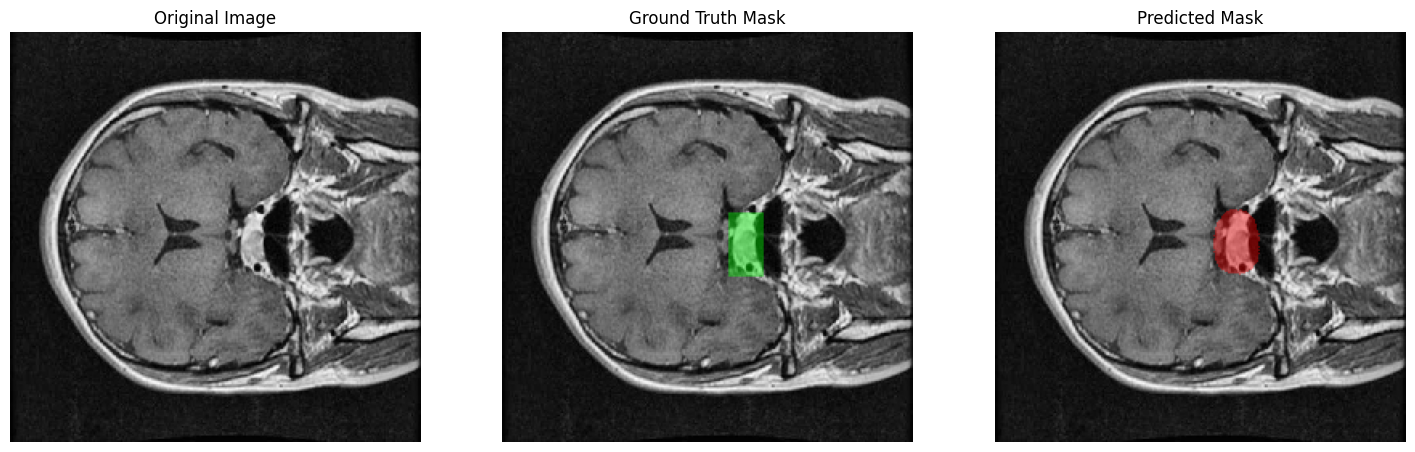

In [32]:
visualize_prediction(sample_img, sample_true_mask, sample_pred_mask)